## 연습문제 7번 

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [5]:
# 데이터셋을 그림으로 만들자

X_train, y_train = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels


In [33]:
X_train, X_validation, X_test = X_train.reshape((-1,28,28,1)), X_validation.reshape((-1,28,28,1)), X_test.reshape((-1,28,28,1))

float32
(55000, 28, 28, 1)


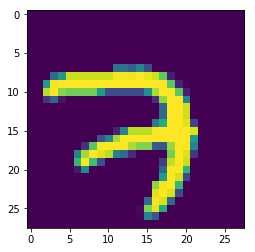

In [35]:
print(X_train.dtype)
print(X_train.shape)
plt.imshow(X_train[0].reshape(28,28));

In [23]:
y_train.dtype

dtype('uint8')

In [168]:
# CNN을 만들어보자
tf.reset_default_graph()

with tf.name_scope("Input"):
    X = tf.placeholder(dtype=tf.float32, shape=(None, 28, 28, 1), name="X")
    y = tf.placeholder(dtype=tf.int64, shape=(None), name="Y")
    
conv1 = tf.layers.conv2d(X, 30, (3,3), padding="same", 
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, 30, (3,3), padding="same", 
                         activation=tf.nn.relu, name="conv2")
lrn = tf.nn.local_response_normalization(conv2, name="LRN")
max_pool1 = tf.layers.max_pooling2d(lrn, pool_size=(2,2), strides=(2,2), name="max1")
conv3 = tf.layers.conv2d(max_pool1, 30, (3,3), padding="same", 
                         activation=tf.nn.relu, name="conv3")
conv4 = tf.layers.conv2d(conv3, 30, (3,3), padding="same",
                        activation=tf.nn.relu, name="conv4")
max_pool2 = tf.layers.max_pooling2d(conv4, (2,2), strides=(2,2), name="max2")
reshape = tf.reshape(max_pool2, (-1, 7*7*30), name="reshape") # 이거 안해주면 안됨
fc1 = tf.layers.dense(reshape, 100, activation=tf.nn.relu, name="fc1")
fc2 = tf.layers.dense(fc1, 100, activation=tf.nn.relu, name="fc2")
output_logits = tf.layers.dense(fc2, 10, name="logits")

with tf.name_scope("Loss"):
    entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=output_logits)
    loss = tf.reduce_mean(entropy, name="loss")
    
with tf.name_scope("Evaluation"):
    y_pred = tf.argmax(output_logits, axis=1)
    correct = tf.equal(y_pred, y)
    accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))

with tf.name_scope("Train"):
    global_step = tf.train.get_or_create_global_step()
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss, global_step = global_step)
    

In [171]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print(accuracy.eval(feed_dict={X: X_train[:10], y:y_train[:10]}))

0.1


In [66]:
## 학습
# 환경 설정
n_epoch = 10
batch_size = 10000
n_train_samples = X_train.shape[0]

# # Summary
# from datetime import datetime
# now = datetime.now().strftime("%Y%m%d%H%M%S")
# logdir = "./ch11/log/run-{}".format(now)
# loss_summary = tf.summary.scalar("loss", loss) # scalar 를 그래프에 먼저 추가해주고 file_writer 만들어야 하는듯..? 아닌가?
# with tf.name_scope("accuracy"):
#     val_acc_summary = tf.summary.scalar("validation", accuracy)
#     train_acc_summary = tf.summary.scalar("train", accuracy)
# file_writer = tf.summary.FileWriter(logdir = logdir, graph = tf.get_default_graph()) 


#Initializer
init = tf.global_variables_initializer()

# Saver
saver = tf.train.Saver() # 무조건 맨 마지막에 나와야하는 느낌..?

with tf.Session() as sess:
    sess.run(init)
    # 조기 종료 변수
    distance_to_best = 0
    best_val_acc = 0.0
    for epoch in range(n_epoch):
        new_idx = np.random.permutation(n_train_samples)
        X_train = X_train[new_idx]
        y_train = y_train[new_idx]
        
        for batch in range( n_train_samples // batch_size ):
            start = batch * batch_size
            end = (batch+1) * batch_size
            feed_dict = {X: X_train[start:end], y: y_train[start:end]}
            
            sess.run(training_op, feed_dict=feed_dict)
            
#             # tensorboard summary 기록
#             if batch % 10 == 0:
#                 loss_val, train_acc_summ_eval = sess.run([loss_summary, train_acc_summary], feed_dict=feed_dict)
#                 file_writer.add_summary(loss_val, tf.train.global_step(sess, global_step))
#                 file_writer.add_summary(train_acc_summ_eval, tf.train.global_step(sess, global_step))

        # Accuracy Evaluation
        if epoch % 1 == 0:
            loss_eval, train_acc_eval = sess.run([loss, accuracy], feed_dict=feed_dict)
            val_acc_eval = accuracy.eval({X:X_validation, y:y_validation})
#             file_writer.add_summary(val_acc_summ_eval, tf.train.global_step(sess, global_step))
            
            print(epoch, "Loss:", loss.eval(feed_dict), "Train Acc:", train_acc_eval, "Val Acc:", val_acc_eval)
            if val_acc_eval > best_val_acc :
                distance_to_best = 0
                best_val_acc = val_acc_eval
                save_path = saver.save(sess, "ch12/model/practice7_best_model.ckpt")
            else:
                distance_to_best += 1
        # 조기 종료
        if distance_to_best > 2:
            print("Eearly Stopping..")
            break

    save_path = saver.save(sess, "ch12/model/practice7_model_final.ckpt")
#     file_writer.close() # 꼭 닫아줘야 텐서보드에 잘 나타나는듯

KeyboardInterrupt: 

In [68]:
# 내건 실행이 안되네..? 개오래 걸릴 뿐임..
# 한 번 예시로 올라온걸로 해보자 

import tensorflow as tf

height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"
conv2_dropout_rate = 0.25

pool3_fmaps = conv2_fmaps

n_fc1 = 128
fc1_dropout_rate = 0.5

n_outputs = 10

tf.reset_default_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 14 * 14])
    pool3_flat_drop = tf.layers.dropout(pool3_flat, conv2_dropout_rate, training=training)

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [69]:
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_model")

KeyboardInterrupt: 

In [70]:
# 졸라 오래걸림 

## 연습문제 8번

In [76]:
width = 299
height = 299
channels = 3

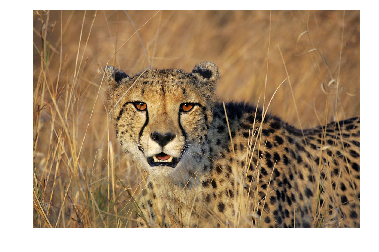

In [100]:
import matplotlib.image as mpimg
test_image = mpimg.imread('/Users/JOLEE/Downloads/animal.jpg')[:, :, :channels]
plt.imshow(test_image)
plt.axis("off")
plt.show()

In [101]:
test_image.shape

(800, 1200, 3)

/Users/JOLEE/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


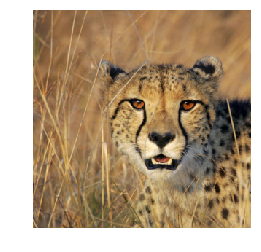

In [139]:
from scipy.misc import imresize

def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # Next, we can select a random location on the image for this bounding box.
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # Let's crop the image using the random bounding box we built.
    image = image[y0:y1, x0:x1]

    # Let's also flip the image horizontally with 50% probability:
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # Now, let's resize the image to the target dimensions.
    image = imresize(image, (target_width, target_height))
    
    # Finally, let's ensure that the colors are represented as
    # 32-bit floats ranging from 0.0 to 1.0 (for now):
    return image.astype(np.float32) / 255

resized_image = prepare_image(test_image, 299, 299)
plt.imshow(resized_image)
plt.axis("off")
plt.show()

In [87]:
import os
import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [88]:
fetch_pretrained_inception_v3()

Downloading: 98%

In [89]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U) # M = Multiline, U = Unicode

def load_class_names():
    with open(os.path.join("datasets", "inception", "imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)

In [93]:
class_names = ["background"] + load_class_names()

In [94]:
class_names[:5]

['background',
 'tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri']

In [95]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
        X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

In [175]:
end_points

{'AuxLogits': <tf.Tensor 'InceptionV3/AuxLogits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'Conv2d_1a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu:0' shape=(?, 149, 149, 32) dtype=float32>,
 'Conv2d_2a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu:0' shape=(?, 147, 147, 32) dtype=float32>,
 'Conv2d_2b_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu:0' shape=(?, 147, 147, 64) dtype=float32>,
 'Conv2d_3b_1x1': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 73, 73, 80) dtype=float32>,
 'Conv2d_4a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 71, 71, 192) dtype=float32>,
 'Logits': <tf.Tensor 'InceptionV3/Logits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'MaxPool_3a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_3a_3x3/MaxPool:0' shape=(?, 73, 73, 64) dtype=float32>,
 'MaxPool_5a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 35, 35, 192) dtype=floa

In [141]:
X_test = resized_image.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})
    

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


In [142]:
most_likely_class_index = np.argmax(predictions_val[0])
most_likely_class_index
class_names[most_likely_class_index]

'cheetah, chetah, Acinonyx jubatus'

In [143]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:] # k 번째 이후로는 큰값, 그 전에는 작은값, 으로 분류만 # 다 정렬하면 연산량이 많아서 인듯
top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[0][i]))

cheetah, chetah, Acinonyx jubatus: 92.80%
lion, king of beasts, Panthera leo: 0.17%
jaguar, panther, Panthera onca, Felis onca: 0.14%
leopard, Panthera pardus: 0.13%
lynx, catamount: 0.10%


## 연습문제 9번

In [120]:
import sys
import tarfile
from six.moves import urllib

FLOWERS_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
FLOWERS_PATH = os.path.join("datasets", "flowers")

def fetch_flowers(url=FLOWERS_URL, path=FLOWERS_PATH):
    if os.path.exists(FLOWERS_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "flower_photos.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    flowers_tgz = tarfile.open(tgz_path)
    flowers_tgz.extractall(path=path)
    flowers_tgz.close()
    os.remove(tgz_path)

In [121]:
fetch_flowers()

Downloading: 100%

In [122]:
flowers_root_path = os.path.join(FLOWERS_PATH, "flower_photos")
flower_classes = sorted([dirname for dirname in os.listdir(flowers_root_path)
                  if os.path.isdir(os.path.join(flowers_root_path, dirname))])
flower_classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [123]:
from collections import defaultdict

image_paths = defaultdict(list)

for flower_class in flower_classes:
    image_dir = os.path.join(flowers_root_path, flower_class)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".jpg"):
            image_paths[flower_class].append(os.path.join(image_dir, filepath))

In [124]:
for paths in image_paths.values():
    paths.sort()   

Class: daisy


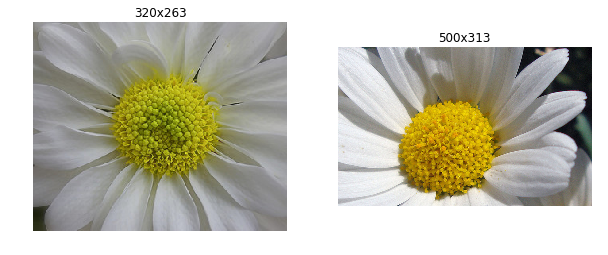

Class: dandelion


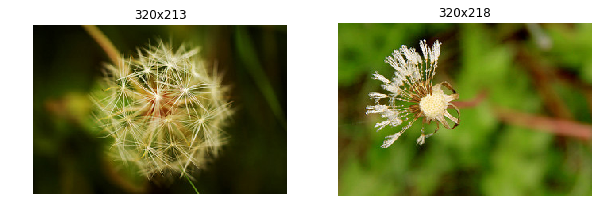

Class: roses


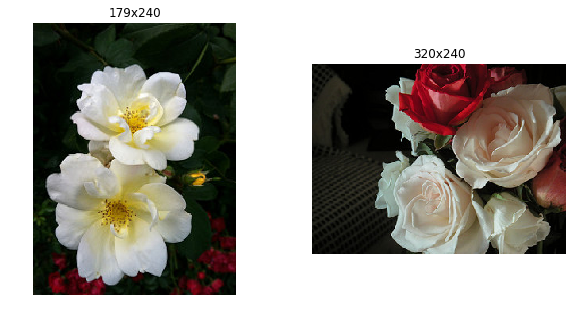

Class: sunflowers


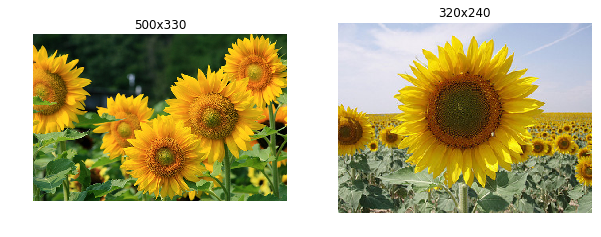

Class: tulips


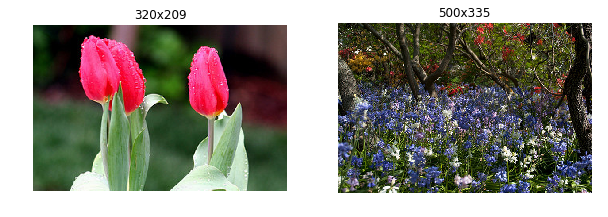

In [125]:
import matplotlib.image as mpimg

n_examples_per_class = 2

for flower_class in flower_classes:
    print("Class:", flower_class)
    plt.figure(figsize=(10,5))
    for index, example_image_path in enumerate(image_paths[flower_class][:n_examples_per_class]):
        example_image = mpimg.imread(example_image_path)[:, :, :channels]
        plt.subplot(100 + n_examples_per_class * 10 + index + 1)
        plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
        plt.imshow(example_image)
        plt.axis("off")
    plt.show()

In [137]:
from scipy.misc import imresize

def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # Next, we can select a random location on the image for this bounding box.
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # Let's crop the image using the random bounding box we built.
    image = image[y0:y1, x0:x1]

    # Let's also flip the image horizontally with 50% probability:
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # Now, let's resize the image to the target dimensions.
    image = imresize(image, (target_width, target_height))
    
    # Finally, let's ensure that the colors are represented as
    # 32-bit floats ranging from 0.0 to 1.0 (for now):
    return image.astype(np.float32) / 255

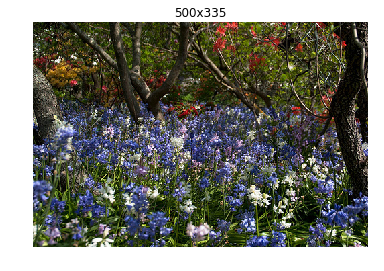

In [144]:
plt.figure(figsize=(6, 8))
plt.imshow(example_image)
plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
plt.axis("off")
plt.show()

/Users/JOLEE/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


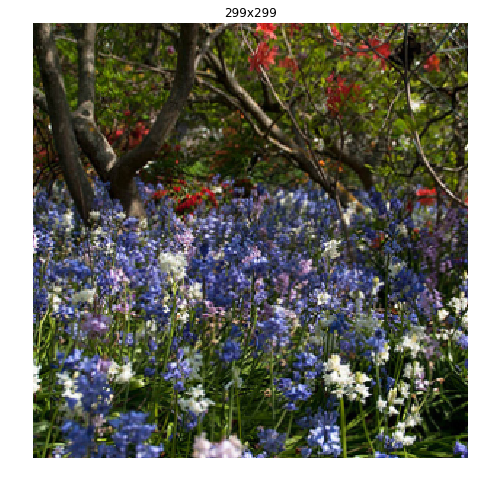

In [145]:
prepared_image = prepare_image(example_image)

plt.figure(figsize=(8, 8))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

/Users/JOLEE/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


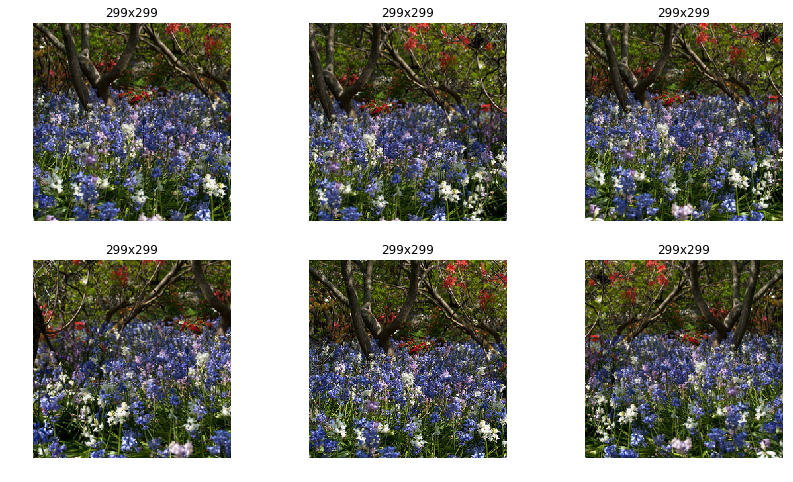

In [146]:
rows, cols = 2, 3

plt.figure(figsize=(14, 8))
for row in range(rows):
    for col in range(cols):
        prepared_image = prepare_image(example_image)
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
        plt.imshow(prepared_image)
        plt.axis("off")
plt.show()


In [147]:
def prepare_image_with_tensorflow(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    image_shape = tf.cast(tf.shape(image), tf.float32)
    height = image_shape[0]
    width = image_shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = tf.cond(crop_vertically,
                         lambda: width,
                         lambda: height * target_image_ratio)
    crop_height = tf.cond(crop_vertically,
                          lambda: width / target_image_ratio,
                          lambda: height)

    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = tf.random_uniform(shape=[], minval=1.0, maxval=1.0 + max_zoom)
    crop_width = tf.cast(crop_width / resize_factor, tf.int32)
    crop_height = tf.cast(crop_height / resize_factor, tf.int32)
    box_size = tf.stack([crop_height, crop_width, 3])   # 3 = number of channels

    # Let's crop the image using a random bounding box of the size we computed
    image = tf.random_crop(image, box_size)

    # Let's also flip the image horizontally with 50% probability:
    image = tf.image.random_flip_left_right(image)

    # The resize_bilinear function requires a 4D tensor (a batch of images)
    # so we need to expand the number of dimensions first:
    image_batch = tf.expand_dims(image, 0)

    # Finally, let's resize the image to the target dimensions. Note that this function
    # returns a float32 tensor.
    image_batch = tf.image.resize_bilinear(image_batch, [target_height, target_width])
    image = image_batch[0] / 255  # back to a single image, and scale the colors from 0.0 to 1.0
    return image

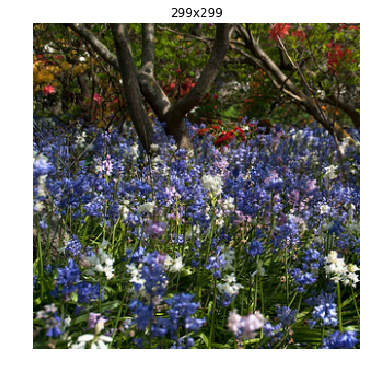

In [148]:
tf.reset_default_graph()

input_image = tf.placeholder(tf.uint8, shape=[None, None, 3])
prepared_image_op = prepare_image_with_tensorflow(input_image)

with tf.Session():
    prepared_image = prepared_image_op.eval(feed_dict={input_image: example_image})
    
plt.figure(figsize=(6, 6))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

In [176]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)

inception_saver = tf.train.Saver()

In [177]:
prelogits = tf.squeeze(end_points["PreLogits"], axis=[1, 2])


In [178]:
n_outputs = len(flower_classes)

with tf.name_scope("new_output_layer"):
    flower_logits = tf.layers.dense(prelogits, n_outputs, name="flower_logits")
    Y_proba = tf.nn.softmax(flower_logits, name="Y_proba")

In [179]:
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=flower_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    flower_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="flower_logits")
    training_op = optimizer.minimize(loss, var_list=flower_vars)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(flower_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() 

In [180]:
[v.name for v in flower_vars]

['flower_logits/kernel:0', 'flower_logits/bias:0']

In [181]:
flower_class_ids = {flower_class: index for index, flower_class in enumerate(flower_classes)}
flower_class_ids

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [182]:
flower_paths_and_classes = []
for flower_class, paths in image_paths.items():
    for path in paths:
        flower_paths_and_classes.append((path, flower_class_ids[flower_class]))

In [183]:
test_ratio = 0.2
train_size = int(len(flower_paths_and_classes) * (1 - test_ratio))

np.random.shuffle(flower_paths_and_classes)

flower_paths_and_classes_train = flower_paths_and_classes[:train_size]
flower_paths_and_classes_test = flower_paths_and_classes[train_size:]

In [184]:
flower_paths_and_classes_train[:3]

[('datasets/flowers/flower_photos/roses/2408236801_f43c6bcff2.jpg', 2),
 ('datasets/flowers/flower_photos/tulips/444963906_e41492b692.jpg', 4),
 ('datasets/flowers/flower_photos/sunflowers/4868595281_1e58083785.jpg', 3)]

In [185]:
from random import sample

def prepare_batch(flower_paths_and_classes, batch_size):
    batch_paths_and_classes = sample(flower_paths_and_classes, batch_size)
    images = [mpimg.imread(path)[:, :, :channels] for path, labels in batch_paths_and_classes]
    prepared_images = [prepare_image(image) for image in images]
    X_batch = 2 * np.stack(prepared_images) - 1 # Inception expects colors ranging from -1 to 1
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    return X_batch, y_batch

In [186]:
X_test, y_test = prepare_batch(flower_paths_and_classes_test, batch_size=len(flower_paths_and_classes_test))

/Users/JOLEE/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [ ]:
n_epochs = 10
batch_size = 40
n_iterations_per_epoch = len(flower_paths_and_classes_train) // batch_size

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

    for epoch in range(n_epochs):
        print("Epoch", epoch, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("  Train accuracy:", acc_train)

        save_path = saver.save(sess, "./my_flowers_model")